# Inferencia
### Metodo para la inferencia de nodos

Se desea realizar un programa en python que se encargue de las tareas de:

* ~~1) Recibir datos del cuestionario.~~
* ~~2) Cargar una red bayesiana en formato BIFXML.~~
* ~~3) Definir estructura de la sub-red bayesiana (red bayesiana temporal).~~
* 4) Generar los CPTS de la sub-red bayesiana.
* 5) Obtener las probabilidades a posteriori de la sub-red (Médiante los métodos propuestos).
* 6) Clasificar los nodos de la sub-red bayesiana.
* 7) Obtener un tema objetivo (siguiente nodo a evaluar).
* 8) Actualizar la red maestra.
* 9) Almacenar la red maestra actualizada en formato BIFXML.

**Programa que tome como entrada:**
* Un grafo (vertices y aristas).
* Nodo pregunta.
* Las tablas de probabilidad condicional de cada nodo.
* Evidencias de los nodos.

**El programa debe obtener por salida:**
* Grafo ponderado con probabilidades a posteriori.
* Categorización de los nodos.

![Diagrama de MPCN](inferencia.PNG "Title")

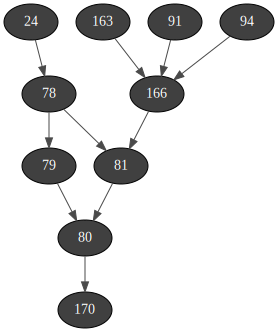


             ||  80                         |
81    |79    ||0        |1        |2        |
------|------||---------|---------|---------|
0     |0     || 0.0000  | 0.0000  | 0.0000  |
1     |0     || 0.0000  | 0.0000  | 0.0000  |
2     |0     || 0.0000  | 0.0000  | 0.0000  |
0     |1     || 0.0000  | 0.0000  | 0.0000  |
1     |1     || 0.0000  | 0.0000  | 0.0000  |
2     |1     || 0.0000  | 0.0000  | 0.0000  |
0     |2     || 0.0000  | 0.0000  | 0.0000  |
1     |2     || 0.0000  | 0.0000  | 0.0000  |
2     |2     || 0.0000  | 0.0000  | 0.0000  |


             ||  80                         |
79    |81    ||0        |1        |2        |
------|------||---------|---------|---------|
0     |0     || 0.2859  | 0.2757  | 0.4384  |
1     |0     || 0.2658  | 0.2633  | 0.4709  |
2     |0     || 0.2792  | 0.2782  | 0.4426  |
0     |1     || 0.2831  | 0.2747  | 0.4422  |
1     |1     || 0.2872  | 0.2687  | 0.4442  |
2     |1     || 0.2614  | 0.2846  | 0.4541  |
0     |2     || 0.2719  | 0.285

In [2]:
# sys.argv devuelve una lista con los parametros pasados por bash.
# sys.argv[1] -> Tendrá el id del nodo evaluado objetivamente.
# sys.argv[2] -> Tendrá la calif. obtenida en el tema evaluado.
import sys
import pyAgrum.lib.notebook as gnb
import pyAgrum as gum
import requests
import numpy as np

class MPCN:
    def __init__(self, parametros):
        self.nodoEvidencia = parametros[1]
        self.ponderacionEvidencia = parametros[2]
        
        #TO-DO: Validaciones
        self.redBayesiana = ""
        self.subRedBayesiana = ""
        #print("Nodo " + self.nodoEvidencia)
        #print("Evidencia " + self.ponderacionEvidencia)

    def cargarRedBayesiana(self, ruta):
        self.redBayesiana=gum.loadBN(ruta)
            
        #gnb.showBN(self.redBayesiana,size=60)
        
    def eliminarRepetidos(self,m):
        if len(m) > 0:
            sr = []
            sr.append(m[0])
            for i in range(1, len(m)):
                v=0
                for a in sr:
                    if m[i]== a:
                        v=1
                if v==0:
                    sr.append(m[i])
            return sr
    
    def crearConexionesEnSubred(self, caminos, nodoCentral, esHaciaArriba):
        conexionesEnString = []
        for camino in caminos:
            if esHaciaArriba == True:
                camino.append(str(nodoCentral))
            else:
                camino.insert(0, str(nodoCentral))
                
            for i in range(len(camino)-1):
                conexionEnString = str(camino[i]) + "->" + str(camino[i+1])
                yaExisteConexion = False
                for conexion in conexionesEnString:
                    if(conexionEnString == conexion):
                        yaExisteConexion = True
                        break
                conexionesEnString.append(conexionEnString)
                if(yaExisteConexion==False):
                    self.subRedBayesiana.addArc( str(camino[i]), str(camino[i+1]) )

    # Retorna una red bayesiana => PyAgrum
    def definirSubRedBayesiana(self):
        caminosAbajo = []
        caminosArriba = []
        nodosDeLaSubRed = []
        adelante=[]
        atras=[]
        self.subRedBayesiana = gum.BayesNet('subred')
        self.subRedBayesiana.add(gum.LabelizedVariable(str(self.nodoEvidencia),str(self.nodoEvidencia),3))
        URL = "http://167.99.228.145/arbol/caminoslibreria"
        respuestaServidor = requests.get(url = URL)
        data = respuestaServidor.json()
        caminos = data['caminos']
        
        for a in caminos:
            for i in range(len(a)):
                if a[i] == int(self.nodoEvidencia):
                    if len(a)-1-i >=3:
                        adelante.append(a[i+1:i+4])
                    else:
                        adelante.append(a[i+1:i+len(a)-i]) 
                    if i >=3:
                        atras.append(a[i-3:i])
                    else:
                        atras.append(a[0:i])
        
        caminosAbajo = self.eliminarRepetidos(adelante)
        caminosArriba = self.eliminarRepetidos(atras)
        for camino in caminosAbajo: nodosDeLaSubRed += camino
        for camino in caminosArriba: nodosDeLaSubRed += camino
            
        nodosDeLaSubRed = self.eliminarRepetidos(nodosDeLaSubRed)
        
        for nodo in nodosDeLaSubRed:
            self.subRedBayesiana.add(gum.LabelizedVariable(str(nodo),str(nodo),3)) # ID, NOMBRE, ESTADOS
        
        self.crearConexionesEnSubred(caminosAbajo, self.nodoEvidencia, False)
        self.crearConexionesEnSubred(caminosArriba, self.nodoEvidencia, True)
        
        gnb.showBN(self.subRedBayesiana,size=60)
                
                
    def cargarCPTSSubRedBayesiana(self):
        gibbs = gum.GibbsSampling(self.redBayesiana)
        gibbs.makeInference()
        copiaRedBayesiana = self.redBayesiana
        
        nodosSubRed = self.subRedBayesiana.nodes()
        for nodo in nodosSubRed:
            nombreNodo = str(self.subRedBayesiana.variable(nodo).name())
            
            padres = self.subRedBayesiana.parents(self.subRedBayesiana.idFromName(nombreNodo))

            padresRedBayesianaMaestra = self.redBayesiana.parents(nombreNodo)
            
            esPadre = True
            padresStr = ""
            padresNodo = []
            for p in padres:
                padresNodo.append(self.subRedBayesiana.variable(p).name())
                padresStr = padresStr + "_" + str(self.subRedBayesiana.variable(p).name())
                esPadre = False
            
            if padresStr == "":
                padresStr = "_"

            
            if esPadre == True:
                self.subRedBayesiana.cpt(nombreNodo).fillWith(gibbs.posterior(nombreNodo)[:])
            else:
                url = "http://167.99.228.145/obtenercpts/" + str(nombreNodo) + "/" + padresStr
                tpcs = requests.get(url).json()[0]
                ii = 0
                for t in tpcs:
                    estados_padres = t['estados_padres'].split("_")[1:]
                    id_padres = padresNodo
                    if t['estado'] == '1':
                        diccionario_padres_estados = {}            
                        for j in range( len(id_padres) ):
                            diccionario_padres_estados[ str(id_padres[j]) ] = int(estados_padres[j]) - 1
                        probabilidades = []
                        probabilidades.append(t['probabilidad'])
                    else:
                        probabilidades.append(t['probabilidad'])
                    if t['estado'] == '3':
                        self.subRedBayesiana.cpt(str(nombreNodo))[diccionario_padres_estados] = probabilidades  
            
            actualizarCPT = False
            for p in padresRedBayesianaMaestra:
                coincidecia = False
                nodoPadreRedBayesiana = self.redBayesiana.variable(p).name()
                for padre in padres:
                    nodoPadreSubRedBayesiana = self.subRedBayesiana.variable(padre).name()
                    if nodoPadreRedBayesiana == nodoPadreSubRedBayesiana:
                        coincidecia = True
                        break
                
                if not coincidecia and not esPadre:
                    copiaRedBayesiana.eraseArc(copiaRedBayesiana.idFromName(nodoPadreRedBayesiana), copiaRedBayesiana.idFromName(nombreNodo))
                    actualizarCPT = True
                    
                    
            
            if actualizarCPT:
                self.subRedBayesiana.cpt(nombreNodo).fillWith(copiaRedBayesiana.cpt(nombreNodo))
                
            print(self.subRedBayesiana.cpt(nombreNodo))
            print(copiaRedBayesiana.cpt(nombreNodo))
            print("Nodo " +  nombreNodo)
            print("Padres en subred " +str(padres) + " Padres en red maestra " + str(padresRedBayesianaMaestra) )
            print("Actualizar cpts ? " + str(actualizarCPT) )
            print("Es padre ? " + str(esPadre) )
            print("________________________________")
            
        
# mpcn = MPCN(sys.argv) Asi se hará en producción. En bash <python MPCN.py 'id_nodo' 'ponderación'>
mpcn = MPCN(['MPCN.py','80','100'])
mpcn.cargarRedBayesiana("red_bayesiana_algebra.bifxml")
mpcn.definirSubRedBayesiana()
mpcn.cargarCPTSSubRedBayesiana()
